# <h1><center>Multi-temporal UAVSAR data coherence map</center></h1>
## This code performs the following coherence analysis with stacked SLC
-  **full coherence map**
-  **Different polarimetric coherence map**
<br>
<br>  Heming Liao, hliao@alaska.edu

In [53]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import math
from dateutil import relativedelta
from datetime import datetime
#from UAVSAR_InSAR_proc import coherence_2SLCs, phase_2SLCs
%run UAVSAR_InSAR_proc.ipynb

Processing site: NISARA
Acquisition dates: 
['190606', '190620', '190701', '190725', '190812', '190923', '190930']
polarization: HH
display/save figures:NISARA
polarization: HV
display/save figures:NISARA
polarization: VH
display/save figures:NISARA
polarization: VV
display/save figures:NISARA
Processing site: winnip
Acquisition dates: 
['120617', '120619', '120622', '120623', '120625', '120627', '120629', '120703', '120705', '120708', '120710', '120713', '120714', '120717']
polarization: HH
display/save figures:winnip
polarization: HV
display/save figures:winnip
polarization: VH
display/save figures:winnip
polarization: VV
display/save figures:winnip
Processing site: SanAnd
Acquisition dates: 
['090908', '091002', '091102', '091117', '091203', '100114', '100115', '100409', '100510', '100511', '100617', '100712', '100810', '100925', '101025', '101110', '101201', '110110', '110330', '110512', '110616', '110712', '110720', '110829', '111003', '111102', '111207', '120105', '120213', '1203

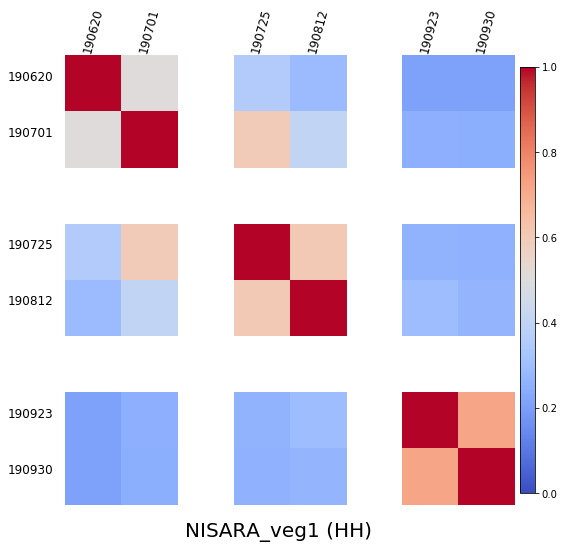

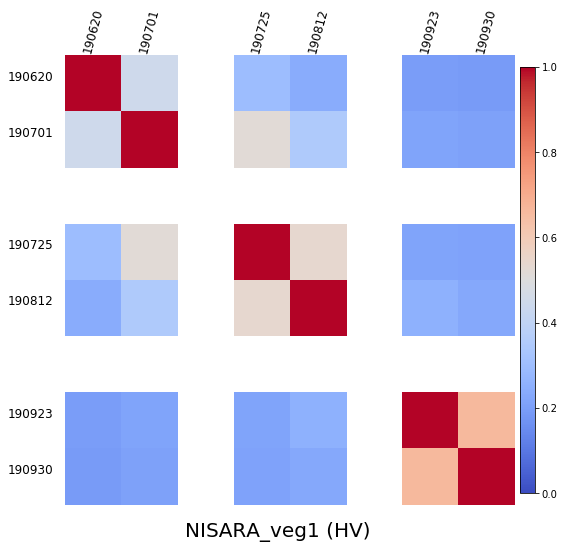

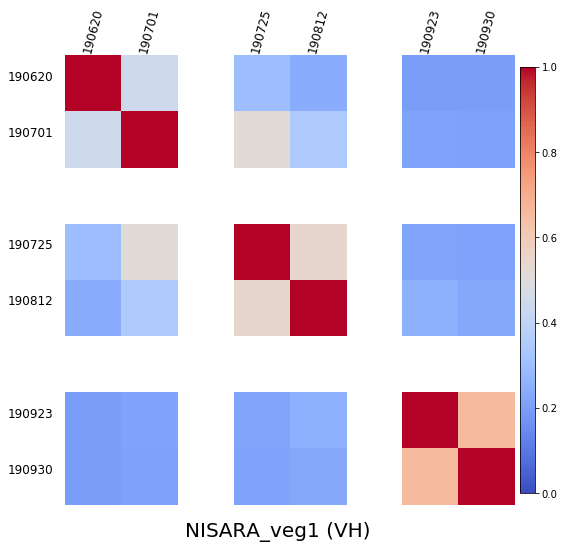

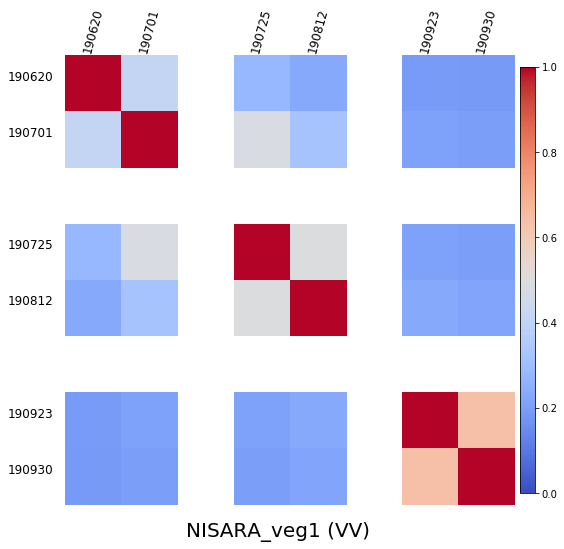

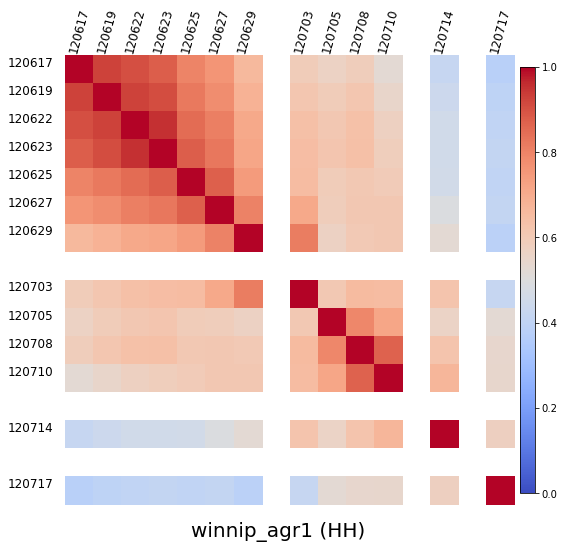

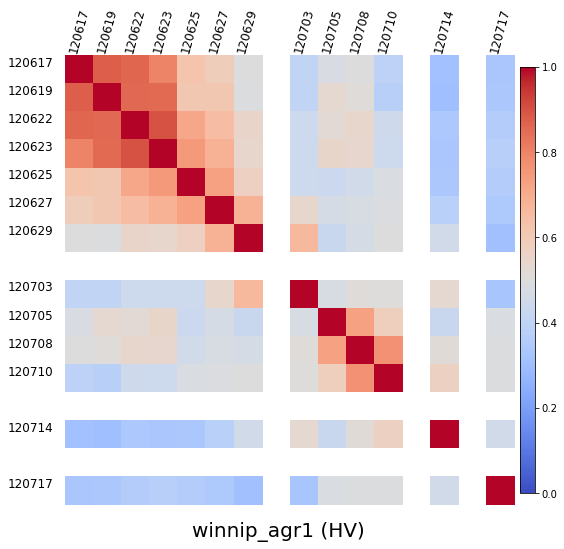

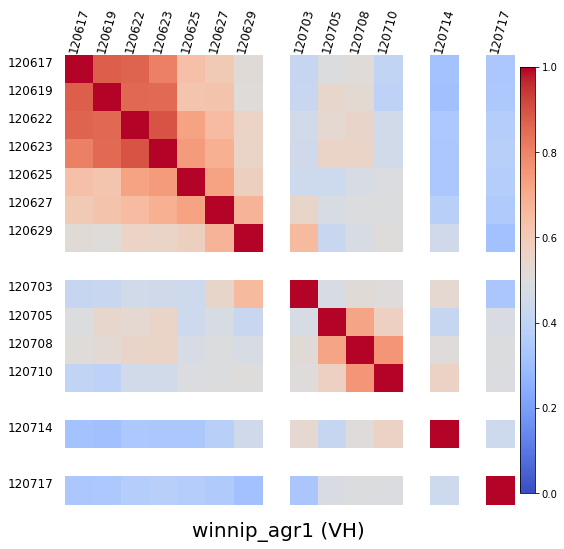

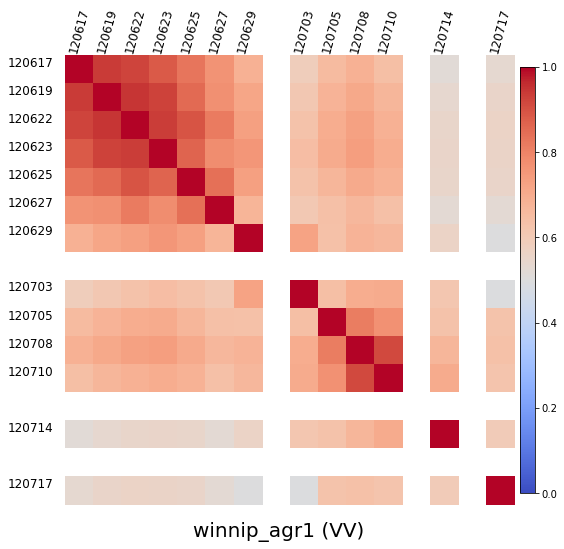

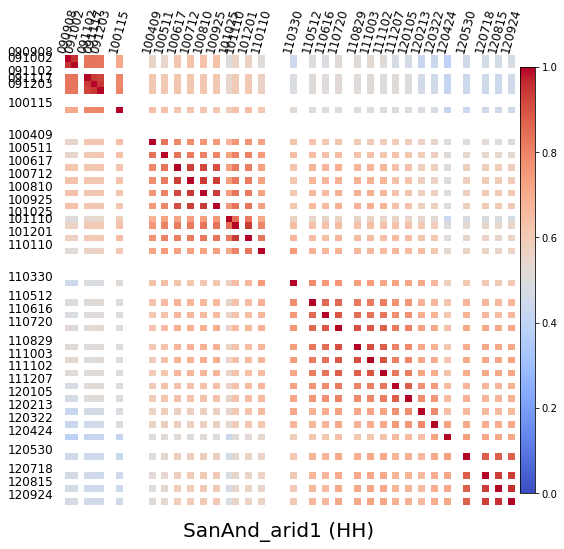

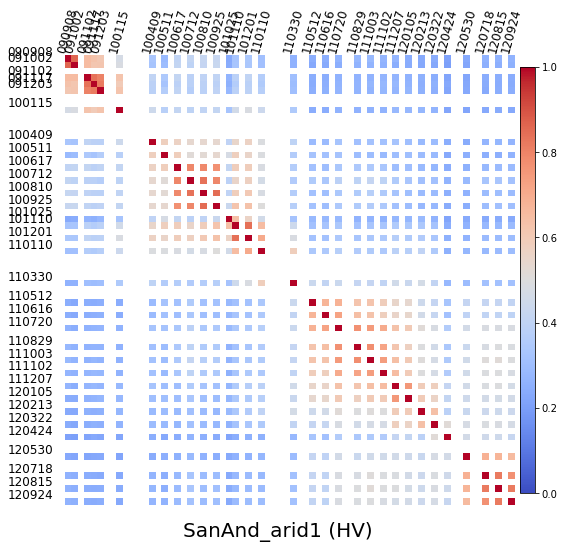

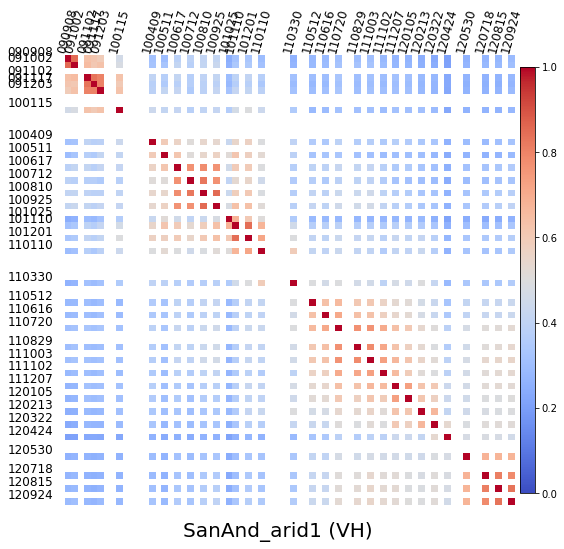

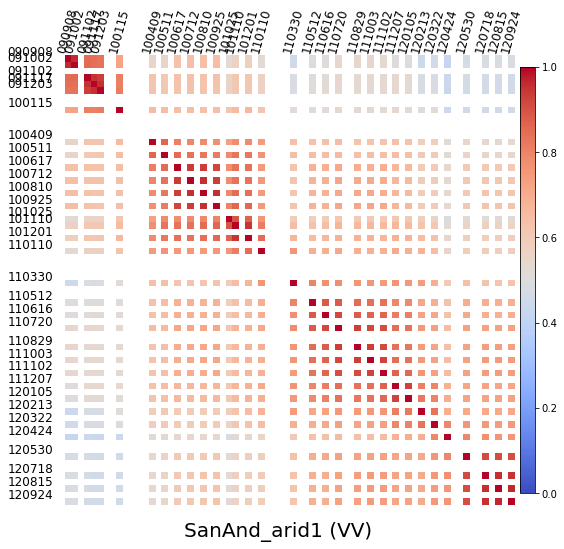

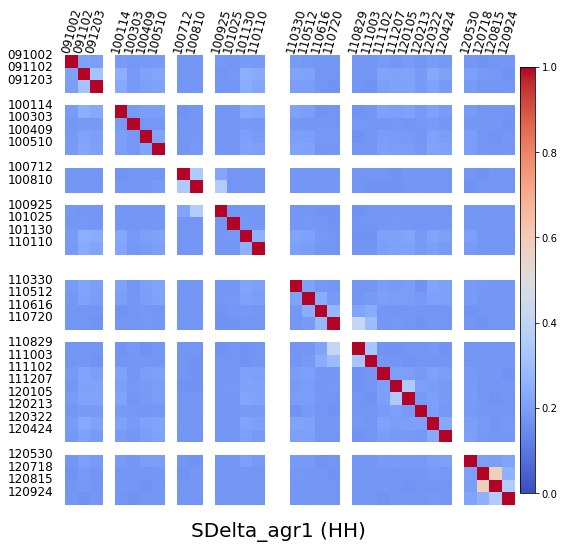

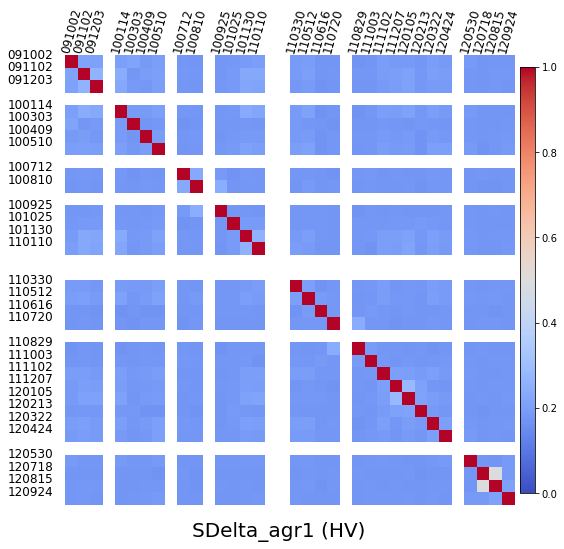

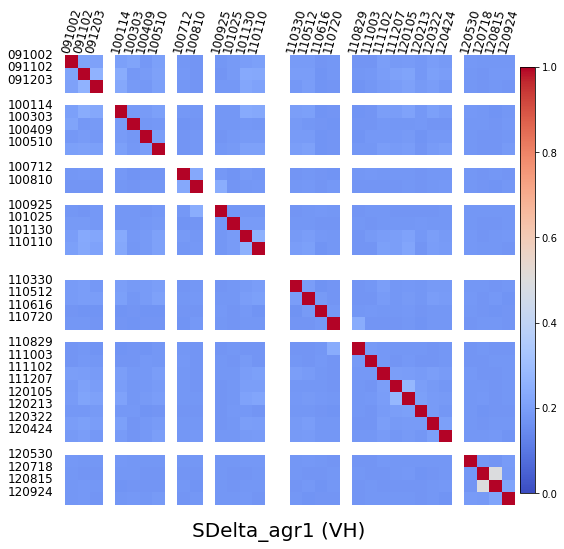

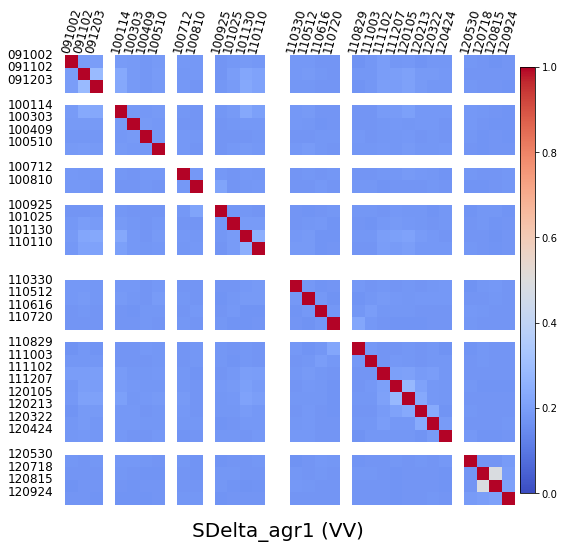

In [99]:
# Approach 1: full coherence matrix of a multi-temporal SLC data. 
#             Coherence grid allocated based on its acquisition date

site_list = ('NISARA_06800','winnip_31606','SanAnd_05508','SDelta_23518')

SLC_data_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data'
output_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data_results'

polarizations = ['HH','HV','VH','VV']

site_temporal_coverage = {site_list[0]:('190606','190930'), site_list[1]:('120617','120717'),
                          site_list[2]:('090908','120924'), site_list[3]:('090908','120924')}

sites_land_type = {'NISARA':['NISARA_veg1'], 'SDelta':['SDelta_agr1'], 
                   'winnip':['winnip_agr1'],'SanAnd':['SanAnd_arid1','SanAnd_mout1']}

# process data 'SanAnd_05508','SDelta_23518'
# calculate every possible combination for coherence maps ...
# locate the coherence map approximately according to master/slave acquisition dates

for site in site_list:
    
    print('Processing site: ' + site.split("_")[0] + '\n' + 'Acquisition dates: ')
    
    index = site_list.index(site)
    
    # acquisitions' date list for UAVSAR site: site
    temp = [fileName.split('/')[7].split('_')[1]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.npy'))]
    acq_dates = sorted(temp)
    
    # selected UAVSAR acquisitions coverage from date1 to date2
    date1 = datetime.strptime(site_temporal_coverage[site][0],'%y%m%d')
    date2 = datetime.strptime(site_temporal_coverage[site][-1],'%y%m%d')
    
    # convert date str to decimal number
    acq_dates_dec_Num = [ datetime.timestamp(datetime.strptime(date_temp,'%y%m%d')) for date_temp in acq_dates]
    
    # calculate coherence map year by year
    date_start = datetime.timestamp(date1)
    date_end = datetime.timestamp(date2)
    acq_dates_selected = [datetime.fromtimestamp(x).strftime('%y%m%d') for x in acq_dates_dec_Num if date_start <= x <= date_end]
    print(acq_dates_selected)
    
    # load the land-cover mask
    mask_file = sites_land_type[site.split('_')[0]][0]  + '_' + 'polygon_mask.npy'
    land_cover_mask = np.load(mask_file)
    
    # calculate coherence matrix dimension
    delta_T_total = (date2 - date1).days + 1

    # Allocate month_grid_N grids for each month on the cohrence map. 
    # month_grid_N will be decided manually based on acquisition frequency
    month_grid_N = np.array([16, 2, 16, 31])
    array_dimension = np.ceil(delta_T_total/month_grid_N[index])

    # coherence map for each specific polarizations
    for count,pol in enumerate(polarizations):
        print('polarization: ' + pol)
        # plot the cohrence map
        fig,axes = plt.subplots(nrows=int(array_dimension),ncols=int(array_dimension),
                                figsize=(8,8),sharex=True,sharey=True)
    
        coherence_map_index = np.ones((int(array_dimension),int(array_dimension)))
        for jj in range(len(acq_dates_selected)):
            for kk in range(jj,len(acq_dates_selected)):
                # define the location for this specific subplot
                datetime1 = datetime.strptime(acq_dates_selected[kk],'%y%m%d')
                delta_T1 = (datetime1-date1).days + 1
                col_index = np.ceil(delta_T1/month_grid_N[index])
            
                datetime2 = datetime.strptime(acq_dates_selected[jj],'%y%m%d')
                delta_T2 = (datetime2 - date1).days + 1
                # np.ceil() add one to avoid zero index
                row_index = np.ceil(delta_T2/month_grid_N[index])
                        
                # subplot location: axes[row_index][col_index]                
                slc1 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_selected[jj] + 
                            '_rg6_azi16_ML_SLC.npy'))
                slc2 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_selected[kk] + 
                            '_rg6_azi16_ML_SLC.npy'))
                cc = coherence_2SLCs(slc1[:,:,count],slc2[:,:,count])               

                land_cover_cc_ave = np.mean(cc[land_cover_mask])*np.ones((2,2))
            
                # display the coherence
                img1 = axes[int(row_index-1),int(col_index-1)].imshow(land_cover_cc_ave,vmin=0,vmax=1,cmap='coolwarm')
                img2 = axes[int(col_index-1),int(row_index-1)].imshow(land_cover_cc_ave,vmin=0,vmax=1,cmap='coolwarm')

                # make spines (the box) and ticks/ticklabels invisible
                plt.setp(axes[int(row_index-1),int(col_index-1)].spines.values(), visible=False)
                plt.setp(axes[int(col_index-1),int(row_index-1)].spines.values(), visible=False)
                axes[int(row_index-1),int(col_index-1)].set(xticks=[],xticklabels=[],yticks=[],yticklabels=[],aspect='auto')
                axes[int(col_index-1),int(row_index-1)].set(xticks=[],xticklabels=[],yticks=[],yticklabels=[],aspect='auto')

                # plot data acquisition dates on x,y axis
                if (row_index-1 == 0):
                    axes[int(row_index-1)][int(col_index-1)].set_xlabel(acq_dates_selected[kk],FontSize=12,rotation=75,ha='right')
                    axes[int(row_index-1)][int(col_index-1)].xaxis.set_label_position('top')
                    axes[int(col_index-1)][int(row_index-1)].set_ylabel(acq_dates_selected[kk],ha='center',labelpad=35,FontSize=12,rotation=0)
                    axes[int(col_index-1)][int(row_index-1)].yaxis.set_label_position("left")
            
                # plot a shared colorbar at right side of the figure
                if (jj == kk & jj == len(acq_dates_selected)-1):
                    cax = fig.add_axes([0.92, 0.1, 0.025, 0.74])
                    fig.colorbar(img2, cax=cax, orientation='vertical')
            
                # mark the location of the subplot
                coherence_map_index[int(row_index-1),int(col_index-1)] = 0
                coherence_map_index[int(col_index-1),int(row_index-1)] = 0
                
        # remove blank grid axes layout
        xy_loc = np.where(coherence_map_index == 1)
        N_xx_yy = np.asarray(xy_loc).T
        for ii in range(N_xx_yy.shape[0]):
            axes[N_xx_yy[ii][0],N_xx_yy[ii][1]].set_axis_off()

        fig.suptitle(sites_land_type[site.split('_')[0]][0] + ' (' + pol + ')', fontsize=20,y=0.05)
        fig.subplots_adjust(left=0.13, bottom=0.08, right=0.91, top=0.86, wspace=0.0, hspace=0.0)
    
        print('display/save figures:' + site.split('_')[0])
        outfile = os.path.join(output_dir, site.split("_")[0] + '_' + pol + '_full_coherence_map')
        fig.savefig(outfile,dpi=300)
        
        

In [ ]:
## Approach 2: plot the coherence in a non-void matrix. 
#.             Without locating the coherence map by its acquisition dates
'''
site_list = ('NISARA_06800','winnip_31606','SanAnd_05508','SDelta_23518')

SLC_data_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data'
output_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data_results'

polarizations = ['HH','HV','VH','VV']

site_temporal_coverage = {site_list[0]:('190606','190930'), site_list[1]:('120617','120717'),
                          site_list[2]:('090908','120924'), site_list[3]:('090908','120924')}

sites_land_type = {'NISARA':['NISARA_veg1'], 'SDelta':['SDelta_agr1'], 
                   'winnip':['winnip_agr1'],'SanAnd':['SanAnd_arid1','SanAnd_mout1']}

# for dataset: 'NISARA_06800','winnip_31606'
# calculate the coherence map for every possible combination
for site in site_list[:2]:
    
    print('Processing data: ' + site.split("_")[0])
    
    # acquisitions' date list for UAVSAR site: site
    temp = [fileName.split('/')[7].split('_')[1]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.npy'))]
    acq_dates = sorted(temp)

    fig = plt.figure(figsize=(16,24))
    
    index1 = acq_dates.index(site_temporal_coverage[site][0])
    index2 = acq_dates.index(site_temporal_coverage[site][-1])
    
    for jj in range(index1,index2+1):
        for kk in range(jj,index2+1):
                slc1 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates[jj] + 
                                '_rg6_azi16_ML_SLC.npy'))
                slc2 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates[kk] + 
                                '_rg6_azi16_ML_SLC.npy'))
                cc = coherence_2SLCs(slc1[:,:,0],slc2[:,:,0]) # HH channel                
                ax1 = fig.add_subplot(index2-index1+1,index2-index1+1,(jj-index1)*(index2-index1+1)+(kk-index1+1))
                img = ax1.imshow(cc,cmap='gray',vmin = 0, vmax = 1)
                ax1.set_xticklabels([])
                ax1.set_yticklabels([])
                #plt.xticks(visible=False)
                #plt.yticks(visible=False)
                if (jj == 0):
                    ax1.set_title(acq_dates[kk],FontSize=18)
                if (kk == jj):
                    ax1.set_ylabel(acq_dates[jj],FontSize=18)
                if (jj == index2-1) and (kk == index2-1):
                    cbaxes = fig.add_axes([0.2, 0.1, 0.5, 0.02])
                    cb = plt.colorbar(img,cax = cbaxes,orientation='horizontal')
          
    fig.suptitle(site.split("_")[0], fontsize=20)
    fig.subplots_adjust(left=0.03, bottom=0.04, right=0.99, top=0.92, wspace=0.01, hspace=0.01)
    
    print('display/save figures:' + site.split('_')[0])
    outfile = os.path.join(output_dir,'1-' + site.split("_")[0] + '_full_coherence_map')
    fig.savefig(outfile, dpi=300)
'''

In [ ]:
## Approach 3: plot the coherence year by year
#              coherence grid allocated based on its acquisition date

'''
site_list = ('NISARA_06800','winnip_31606','SanAnd_05508','SDelta_23518')

SLC_data_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data'
output_dir = '/Users/hliao/Documents/UAF_work/coherence/npy_new_data_results'

polarizations = ['HH','HV','VH','VV']

site_temporal_coverage = {site_list[0]:('190606','190930'), site_list[1]:('120617','120717'),
                          site_list[2]:('090908','120924'), site_list[3]:('090908','120924')}

sites_land_type = {'NISARA':['NISARA_veg1'], 'SDelta':['SDelta_agr1'], 
                   'winnip':['winnip_agr1'],'SanAnd':['SanAnd_arid1','SanAnd_mout1']}

# process data 'SanAnd_05508','SDelta_23518'
# Calculate coherence of every possible combination ...
# ... and locate the coherence map according to the master/slave acquisition dates

for site in site_list[2:]:
    
    print('Processing data: ' + site.split("_")[0])
    
    # acquisitions' date list for UAVSAR site: site
    temp = [fileName.split('/')[7].split('_')[1]
            for fileName in glob.glob(os.path.join(SLC_data_dir,site.split('_')[0]+'*.npy'))]
    acq_dates = sorted(temp)
    
    # UAVSAR acquisition spanning years
    date1 = datetime.strptime(acq_dates[0],'%y%m%d')
    year1 = date1.year
    date2 = datetime.strptime(acq_dates[-1],'%y%m%d')
    year2 = date2.year
    
    # convert date str to decimal number
    acq_dates_dec_Num = [ datetime.timestamp(datetime.strptime(date_temp,'%y%m%d')) for date_temp in acq_dates]
    
    # calculate coherence map year by year
    for ii in range(year1,year2):
        year_start = datetime.timestamp(datetime.strptime(str(ii),'%Y'))
        year_end = datetime.timestamp(datetime.strptime(str(ii+1),'%Y'))
        acq_dates_a_year = [datetime.fromtimestamp(x).strftime('%y%m%d') for x in acq_dates_dec_Num if year_start <= x < year_end]
        print(acq_dates_a_year)
        
        deltatime_between_acqs = [ (datetime.strptime(acq_dates_a_year[ii+1],'%y%m%d')
                                  - datetime.strptime(acq_dates_a_year[ii],'%y%m%d')).days
                                  for ii in range(len(acq_dates_a_year[:-1]))]
        
        fig = plt.figure(figsize=(24,24))
        #plt.rcParams['xtick.bottom'] = plt.rcParams['xtick.labelbottom'] = False
        #plt.rcParams['xtick.top'] = plt.rcParams['xtick.labeltop'] = True
        
        for jj in range(len(acq_dates_a_year)):
            for kk in range(jj,len(acq_dates_a_year)):
                # calculate coherence
                slc1 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_a_year[jj] + 
                                '_rg6_azi16_ML_SLC.npy'))
                slc2 = np.load(os.path.join(SLC_data_dir, site.split('_')[0] + '_' + acq_dates_a_year[kk] + 
                                '_rg6_azi16_ML_SLC.npy'))
                cc = coherence_2SLCs(slc1[:,:,0],slc2[:,:,0]) # HH channel       
                
                # define the location for this specific subplot
                datetime1 = datetime.strptime(acq_dates_a_year[kk],'%y%m%d')
                datetime2 = datetime.strptime(acq_dates_a_year[jj],'%y%m%d')
                
                delta_days1 = (datetime1 - datetime.strptime(str(datetime1.year),'%Y')).days
                delta_days2 = (datetime2 - datetime.strptime(str(datetime1.year),'%Y')).days
                total_days = (datetime.fromtimestamp(year_end) - datetime.fromtimestamp(year_start)).days
                x_location = delta_days1/total_days
                y_location = delta_days2/total_days
                min_deltatime_acqs = np.min(deltatime_between_acqs)
                width1 = np.max([12,min_deltatime_acqs])/total_days - 0.001
                width2 = 1/(len(acq_dates_a_year)) - 0.001
                if (width1<=width2):
                    width = width1
                else:
                    width = width2
                height = width
                
                if ((kk==jj) | ((datetime1 - datetime2).days>=12)):
                    axes = fig.add_axes([x_location-width/2, 1-(y_location+height)-0.02, width, height]) # [left, bottom, width, height]
                    axes.imshow(cc,cmap='gray', vmin = 0, vmax = 1)
                    axes.set_xticklabels([])
                    axes.set_yticklabels([])
                    if (jj == 0):                
                        axes.set_xlabel(acq_dates_a_year[kk],FontSize=18,labelpad=0.001*slc2.shape[0],rotation=0)
                        axes.xaxis.set_label_position('top')
                    if (kk == len(acq_dates_a_year)-1):
                        axes.set_ylabel(acq_dates_a_year[jj],FontSize=18,labelpad=0.02*slc2.shape[1],rotation=0)
                        axes.yaxis.set_label_position("right")
                        axes.yaxis.tick_right()

        fig.suptitle(site.split("_")[0] + '(' + str(ii) + ')', fontsize=20,y=0.1)
        fig.subplots_adjust(left=0.06, bottom=0.04, right=0.96, top=0.90, wspace=0.001, hspace=0.001)
    
        print('display/save figures:' + site.split('_')[0])
        outfile = os.path.join(output_dir,'1-' + site.split("_")[0] + '_' + str(ii) + '_full_coherence_map')
        fig.savefig(outfile,dpi=300)
'''